In [21]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

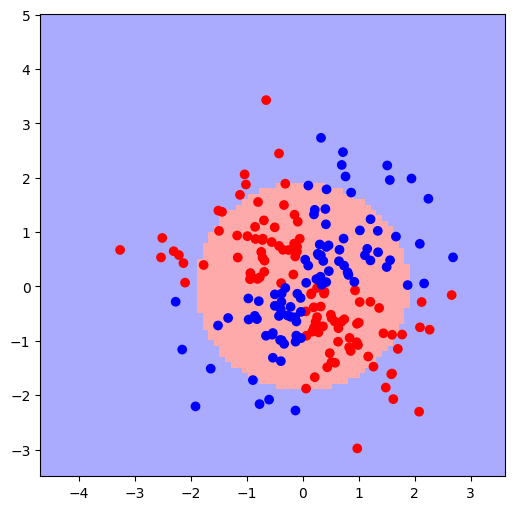

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
#        self.l1 = nn.Linear(input_size,nodes)
#        self.activation = nn.Tanh()

    def forward(self,x):
#        output = self.l1(x)
#        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



In [23]:
#  Define the FFNN model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x  # Raw logits for CrossEntropyLoss



In [24]:
# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1000):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                val_running_loss += loss.item() * inputs.size(0)
            val_loss = val_running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)
        
        # Optionally print progress
        if (epoch+1) % 100 == 0 or epoch == 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    return train_losses, val_losses

# Function to split data manually
def manual_train_val_split(X, y, val_ratio=0.2):
    # Shuffle the data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    # Calculate split index
    split_idx = int(len(X) * (1 - val_ratio))
    
    # Split the data
    X_train = X_shuffled[:split_idx]
    y_train = y_shuffled[:split_idx]
    X_val = X_shuffled[split_idx:]
    y_val = y_shuffled[split_idx:]
    
    return X_train, y_train, X_val, y_val


Processing dataset: xor
Shape of X_train_full after removing bias term: (200, 2)
Shape of X_valid after removing bias term: (200, 2)
Shape of X_test after removing bias term: (200, 2)

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.6908, Validation Loss: 0.7061
Epoch [100/1000], Training Loss: 0.6456, Validation Loss: 0.6794
Epoch [200/1000], Training Loss: 0.5635, Validation Loss: 0.6055
Epoch [300/1000], Training Loss: 0.5071, Validation Loss: 0.5676
Epoch [400/1000], Training Loss: 0.4868, Validation Loss: 0.5630
Epoch [500/1000], Training Loss: 0.4798, Validation Loss: 0.5651
Epoch [600/1000], Training Loss: 0.4774, Validation Loss: 0.5692
Epoch [700/1000], Training Loss: 0.4762, Validation Loss: 0.5711
Epoch [800/1000], Training Loss: 0.4758, Validation Loss: 0.5739
Epoch [900/1000], Training Loss: 0.4756, Validation Loss: 0.5742
Epoch [1000/1000], Training Loss: 0.4753, Validation Loss: 0.5747
Validation Accuracy for k=2: 0.7050

Training with hidden layer 

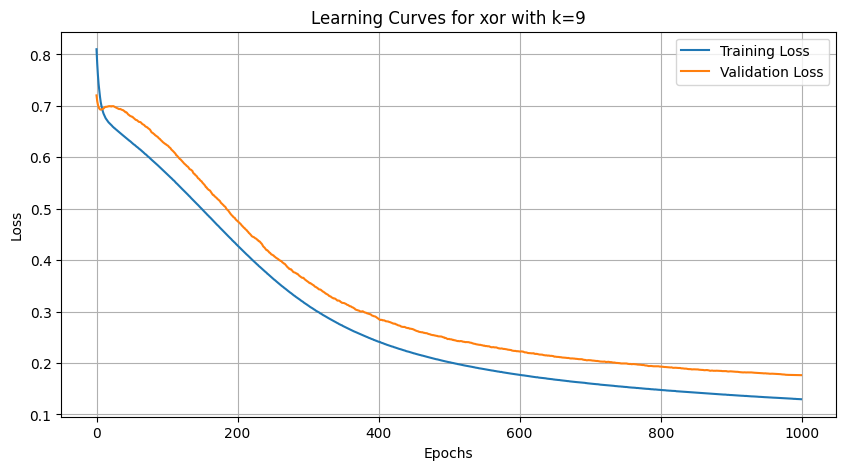

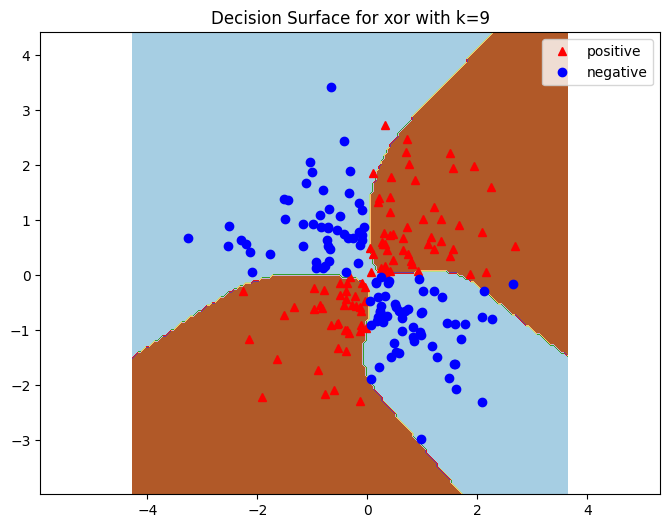

In [29]:
# Main execution loop
datasets = ['xor']  # You can include other datasets like 'center_surround', 'two_gaussians', 'spiral'

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Read the datasets
    X_train, y_train, labels_train = read_data(dataset_name, 'train')
    X_test, y_test, labels_test = read_data(dataset_name, 'test')
    X_valid, y_valid, labels_valid = read_data(dataset_name, 'valid')
    
    # Remove bias term from all datasets if included because pytorch model already accounts for it
    if X_train.shape[1] == 3:  # If bias term is included
        X_train = X_train[:, 1:]  # Remove bias term
        X_valid = X_valid[:, 1:]  # Remove bias term
        X_test = X_test[:, 1:]    # Remove bias term
        print(f"Shape of X_train_full after removing bias term: {X_train.shape}")
        print(f"Shape of X_valid after removing bias term: {X_valid.shape}")
        print(f"Shape of X_test after removing bias term: {X_test.shape}")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long().squeeze()
    X_val_tensor = torch.from_numpy(X_valid).float()
    y_val_tensor = torch.from_numpy(y_valid).long().squeeze()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long().squeeze()

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the range of hidden layer sizes to experiment with
    k_values = [2, 3, 5, 7, 9]
    
    # Initialize variables to keep track of the best model
    best_val_loss = float('inf')
    best_k = None
    best_model = None
    
    # Dictionaries to store training and validation losses for each k
    train_losses_dict = {}
    val_losses_dict = {}
    val_accuracies_dict = {}
    
    # Iterate over different hidden layer sizes
    for k in k_values:
        print(f"\nTraining with hidden layer size k={k}")
        
        # Initialize the model
        model = FFNN(input_size=X_train_tensor.shape[1], hidden_size=k, output_size=2)
        
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Number of epochs
        num_epochs = 1000
        
        # Train the model
        train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
        
        # Store the losses
        train_losses_dict[k] = train_losses
        val_losses_dict[k] = val_losses
        
        # After training, evaluate validation accuracy
        # (This has already been done inside train_model and printed)
        # To store it, you need to capture it during training
        # For simplicity, we'll compute it again here
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
        val_accuracy = correct / total
        val_accuracies_dict[k] = val_accuracy
        print(f"Validation Accuracy for k={k}: {val_accuracy:.4f}")
        
        # Check if this model is the best so far
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k
            best_model = model

    # After evaluating all k's, print a summary table
    print(f"\nSummary of Results for dataset: {dataset_name}")
    print(f"{'k':<5}{'Val Loss':<15}{'Val Accuracy':<15}")
    for k in k_values:
        print(f"{k:<5}{val_losses_dict[k][-1]:<15.4f}{val_accuracies_dict[k]:<15.4f}")
    
    print(f"\nBest k for {dataset_name}: {best_k} with Validation Loss: {best_val_loss:.4f} and Validation Accuracy: {val_accuracies_dict[best_k]:.4f}")
    
    # Evaluate the best model on the test set
    best_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()
    test_accuracy = correct / total
    print(f"Test Accuracy for {dataset_name} with k={best_k}: {test_accuracy:.2f}")
    
    # (a) List hyperparameters
    print(f"\nHyperparameters for {dataset_name}:")
    print(f"Learning Rate: 0.01")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Hidden Layer Size (k): {best_k}")
    print(f"Activation Function: Tanh")
    print(f"Optimizer: SGD")
    
    # (b) Plot learning curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses_dict[best_k], label='Training Loss')
    plt.plot(val_losses_dict[best_k], label='Validation Loss')
    plt.title(f"Learning Curves for {dataset_name} with k={best_k}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (d) Plot decision boundary using provided plotting functions
    # Map labels for plotting (from class indices to -1/+1)
    y_test_np = y_test_tensor.numpy()
    X_test_np = X_test_tensor.numpy()
    labels_test_mapped = np.where(y_test_np == 0, -1, 1)
    
    def model_for_plotting(input_data):
        with torch.no_grad():
            inputs = torch.from_numpy(input_data).float()
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = np.where(predicted.numpy() == 0, -1, 1)
            return predicted_labels
    
    # Compute axis limits based on test data
    axis_limits = [X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1,
                   X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1]
    
    # Plot the decision surface
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model_for_plotting, axis_limits=axis_limits)
    
    # Overlay the test data
    plot_data(X_test_np, labels_test_mapped)
    
    plt.title(f"Decision Surface for {dataset_name} with k={best_k}")
    plt.show()